### 1. Install CatBoost Library
This cell installs the `catboost` library, which is a gradient boosting framework that can handle categorical features automatically. It's often used for machine learning tasks, especially when dealing with tabular data.

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.1/97.1 MB 8.2 MB/s eta 0:00:00


### 2. Import Necessary Libraries
This cell imports all the required Python libraries for data manipulation, machine learning model building, evaluation, and visualization. Key libraries include `pandas` for data handling, `numpy` for numerical operations, `sklearn` for machine learning utilities, `catboost` for the model, `shap` for explainability, and `matplotlib` for plotting.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
import shap
import matplotlib.pyplot as plt
import xgboost as xgb
import joblib
from IPython.display import Image, display
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier

### 3. Load the Dataset
This cell loads the T20 ball-by-ball dataset from a specified GitHub URL into a pandas DataFrame. It includes error handling for `FileNotFoundError` and other potential exceptions during the loading process, and then displays the first few rows of the DataFrame to verify successful loading.

In [ ]:
file_path = 'https://raw.githubusercontent.com/ShiwanthaH/MiddleOverStrikeRateOptimizer/refs/heads/main/Dataset/Final/T20_ball_by_ball.csv'

try:
    df = pd.read_csv(file_path)
    print("Dataset loaded successfully!")
    display(df.head())
except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")

Dataset loaded successfully!


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Extras_Type,Total_Runs_This_Ball,Cumulative_Runs,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR
0,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,0,0,No,NaN,NaN,0,0.0,Pace Friendly,88.89
1,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,0,0,No,NaN,NaN,0,0.0,Pace Friendly,88.89
2,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,1,1,No,NaN,NaN,0,2.0,Pace Friendly,88.89
3,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,2,3,No,NaN,NaN,0,4.5,Pace Friendly,0.00
4,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Australia,1,...,NaN,0,3,No,NaN,NaN,0,3.6,Pace Friendly,0.00


### 4. Filter Data for Sri Lanka Team
This cell filters the main dataset to include only the ball-by-ball data where the `Batting_Team` is 'Sri Lanka'. This focuses the analysis on a specific team.

In [ ]:
df_sl = df[(df['Batting_Team'] == 'Sri Lanka')].copy()

### 5. Preprocess Bowler Types
This cell performs two main preprocessing steps:
1.  **Drop Missing Values**: It removes rows where `Bowler_Type` or `Batter` information is missing, as these are crucial for the analysis.
2.  **Group Bowler Types**: It defines a function `group_bowler` to categorize diverse bowler types (e.g., 'fast', 'medium', 'offbreak', 'legbreak', 'orthodox') into broader groups like 'Pace', 'Off-Spin', 'Leg-Spin', 'Left-Arm Orthodox', and 'Other'. This simplifies the `Bowler_Type` feature. It then applies this function to create a new `Bowler_Group` column.

In [ ]:
df_sl = df_sl.dropna(subset=['Bowler_Type', 'Batter'])

def group_bowler(bt):
    bt = str(bt).lower()
    if 'fast' in bt or 'medium' in bt: return 'Pace'
    if 'offbreak' in bt: return 'Off-Spin'
    if 'legbreak' in bt or 'wrist' in bt: return 'Leg-Spin'
    if 'orthodox' in bt: return 'Left-Arm Orthodox'
    return 'Other'
df_sl['Bowler_Group'] = df_sl['Bowler_Type'].apply(group_bowler)

print(df_sl.shape)
display(df_sl.head())

(25481, 30)


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Total_Runs_This_Ball,Cumulative_Runs,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR,Bowler_Group
125,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,1,1,No,NaN,NaN,0,6.0,Pace Friendly,153.33,Pace
126,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,1,2,No,NaN,NaN,0,6.0,Pace Friendly,128.00,Pace
127,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,0,2,No,NaN,NaN,0,4.0,Pace Friendly,153.33,Pace
128,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,0,2,No,NaN,NaN,0,3.0,Pace Friendly,153.33,Pace
129,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,3,5,No,NaN,NaN,0,6.0,Pace Friendly,153.33,Pace


### 6. Feature Engineering: Batter vs. Bowler Type Strike Rate
This crucial cell engineers a new feature: `Batter_vs_BowlerType_SR`. This feature represents the strike rate of each batter against different bowler groups. Here's how it works:
1.  **Filter Legal Balls**: It excludes wide balls, as they don't count towards a batter's strike rate.
2.  **Aggregate Runs and Balls**: It groups the data by `Batter` and `Bowler_Group` to sum `Total_Runs` and count `Total_Balls` faced.
3.  **Calculate Strike Rate**: The strike rate is calculated as `(Total_Runs / Total_Balls) * 100`.
4.  **Merge Feature**: The calculated strike rate is merged back into the main DataFrame (`df_sl`).
5.  **Handle Missing Values**: Any missing strike rates (e.g., for new batter-bowler matchups) are filled with a default baseline T20 strike rate of 100.0.

In [ ]:
# ==========================================
# FEATURE ENGINEERING: Batter vs Bowler Type SR
# ==========================================

# 1. Filter out wide balls (wides do not count as a ball faced for a batter's strike rate)
# We assume 'Extras_Type' is 'N/A' for normal balls, and contains 'wides' for wide deliveries.
df_legal_balls = df_sl[~df_sl['Extras_Type'].str.contains('wides', case=False, na=False)]

# 2. Calculate total runs and total balls faced for every Batter-BowlerGroup combination
matchup_stats = df_legal_balls.groupby(['Batter', 'Bowler_Group']).agg(
    Total_Runs=('Batter_Runs', 'sum'),
    Total_Balls=('Batter_Runs', 'count')
).reset_index()

# 3. Calculate the Strike Rate: (Runs / Balls) * 100
matchup_stats['Batter_vs_BowlerType_SR'] = (matchup_stats['Total_Runs'] / matchup_stats['Total_Balls']) * 100

# Round to 2 decimal places and handle any rare division-by-zero errors
matchup_stats['Batter_vs_BowlerType_SR'] = matchup_stats['Batter_vs_BowlerType_SR'].fillna(0).round(2)

# 4. Merge the engineered feature back into the main dataframe
df_sl = df_sl.merge(
    matchup_stats[['Batter', 'Bowler_Group', 'Batter_vs_BowlerType_SR']],
    on=['Batter', 'Bowler_Group'],
    how='left'
)

# 5. Fill missing values (e.g., if a batter faces a bowler type for the very first time on a wide ball)
# We fill it with a baseline T20 strike rate of 100.0 to prevent NaN errors in XGBoost
df_sl['Batter_vs_BowlerType_SR'] = df_sl['Batter_vs_BowlerType_SR'].fillna(100.0)

# Verify the new column
print("--- New Feature Engineered Successfully ---")
print(df_sl[['Batter', 'Bowler_Group', 'Batter_vs_BowlerType_SR']].drop_duplicates().head(10))

--- New Feature Engineered Successfully ---
             Batter Bowler_Group  Batter_vs_BowlerType_SR
0       N Dickwella         Pace                   127.57
1       WU Tharanga         Pace                   119.29
14   EMDY Munaweera         Pace                   134.62
39   EMDY Munaweera     Leg-Spin                   137.93
40      N Dickwella     Leg-Spin                   137.21
45   EMDY Munaweera     Off-Spin                    56.25
47      N Dickwella     Off-Spin                    95.45
56    DAS Gunaratne     Leg-Spin                    86.67
57    DAS Gunaratne         Pace                   140.32
68  TAM Siriwardana     Leg-Spin                   111.54


### 7. Filter for Middle Overs
This cell filters the DataFrame `df_sl` to include only balls bowled during the 'middle overs' of a T20 match, specifically overs 7 to 15 (inclusive). This is important because batting strategies often differ significantly in the middle overs compared to powerplay or death overs.

In [ ]:
df_sl = df_sl[(df_sl['Over'].between(7, 15))]

print(df_sl.shape)
display(df_sl.head())

(11653, 31)


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Cumulative_Runs,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR,Bowler_Group,Batter_vs_BowlerType_SR
45,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,69,No,NaN,NaN,1,9.63,Pace Friendly,92.86,Off-Spin,56.25
46,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,70,No,NaN,NaN,1,9.55,Pace Friendly,92.86,Off-Spin,56.25
47,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,70,No,NaN,NaN,1,9.33,Pace Friendly,153.33,Off-Spin,95.45
48,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,71,No,NaN,NaN,1,9.26,Pace Friendly,153.33,Off-Spin,95.45
49,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,72,No,NaN,NaN,1,9.19,Pace Friendly,92.86,Off-Spin,56.25


### 8. Filter for Established Batters
This cell filters out batters who have faced fewer than 100 balls in the middle overs. This ensures that the model is trained on data from 'established' batters, providing more reliable statistics and avoiding noise from players with very limited data.

In [ ]:
batter_counts = df_sl['Batter'].value_counts()
established_batters = batter_counts[batter_counts >= 100].index
df_sl = df_sl[df_sl['Batter'].isin(established_batters)]

print(df_sl.shape)
display(df_sl.head())

(10307, 31)


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Cumulative_Runs,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR,Bowler_Group,Batter_vs_BowlerType_SR
47,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,70,No,NaN,NaN,1,9.33,Pace Friendly,153.33,Off-Spin,95.45
48,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,71,No,NaN,NaN,1,9.26,Pace Friendly,153.33,Off-Spin,95.45
50,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,73,No,NaN,NaN,1,9.12,Pace Friendly,153.33,Off-Spin,95.45
51,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,74,No,NaN,NaN,1,9.06,Pace Friendly,153.33,Leg-Spin,137.21
54,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,79,No,NaN,NaN,1,9.12,Pace Friendly,153.33,Leg-Spin,137.21


### 9. Define Ball Outcome Categories
This cell creates a new target variable `Ball_Outcome` based on the result of each ball. It categorizes each delivery into one of three outcomes:
-   **0: Pressure (Dot/Wicket)**: If a wicket falls or no runs are scored (dot ball).
-   **1: Strike Rotation**: If 1, 2, or 3 runs are scored.
-   **2: Boundary**: If 4 or 6 runs are scored.

This categorization allows the model to predict the tactical intent or outcome of a ball.

In [ ]:
def get_outcome(row):
    if row['Wicket'] == 'Yes' or row['Batter_Runs'] == 0:
        return 0 # Pressure (Dot/Wicket)
    elif row['Batter_Runs'] in [1, 2, 3]:
        return 1 # Strike Rotation
    else:
        return 2 # Boundary
df_sl['Ball_Outcome'] = df_sl.apply(get_outcome, axis=1)

print(df_sl.shape)
display(df_sl.head())

(10307, 32)


,File,Match_Date,Season,City,Venue,Team1,Team2,Winner,Batting_Team,Inning,...,Wicket,Wicket_Mode,Wicket_Player,Cumulative_Wickets,Current_Run_Rate,Venue_Type,Batter_Last5_SR,Bowler_Group,Batter_vs_BowlerType_SR,Ball_Outcome
47,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.33,Pace Friendly,153.33,Off-Spin,95.45,0
48,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.26,Pace Friendly,153.33,Off-Spin,95.45,1
50,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.12,Pace Friendly,153.33,Off-Spin,95.45,1
51,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.06,Pace Friendly,153.33,Leg-Spin,137.21,1
54,1001349.json,2017-02-17,2016/17,NaN,Melbourne Cricket Ground,Australia,Sri Lanka,Sri Lanka,Sri Lanka,2,...,No,NaN,NaN,1,9.12,Pace Friendly,153.33,Leg-Spin,137.21,2


### 10. Prepare Features (X) and Target (y)
This cell defines the features (`X`) that will be used to train the machine learning model and the target variable (`y`) which is `Ball_Outcome`. The selected features include `Batter`, `Bowler_Group`, `Over`, `Cumulative_Wickets`, `Current_Run_Rate`, `Inning`, `Venue_Type`, `Batter_Last5_SR`, and the newly engineered `Batter_vs_BowlerType_SR`.

In [ ]:
features = ['Batter', 'Bowler_Group', 'Over', 'Cumulative_Wickets','Current_Run_Rate', 'Inning', 'Venue_Type', 'Batter_Last5_SR', 'Batter_vs_BowlerType_SR']
X = df_sl[features]
y = df_sl['Ball_Outcome']

print(X.shape, y.shape)
display(X.head())

(10307, 9) (10307,)


,Batter,Bowler_Group,Over,Cumulative_Wickets,Current_Run_Rate,Inning,Venue_Type,Batter_Last5_SR,Batter_vs_BowlerType_SR
47,N Dickwella,Off-Spin,7,1,9.33,2,Pace Friendly,153.33,95.45
48,N Dickwella,Off-Spin,7,1,9.26,2,Pace Friendly,153.33,95.45
50,N Dickwella,Off-Spin,7,1,9.12,2,Pace Friendly,153.33,95.45
51,N Dickwella,Leg-Spin,8,1,9.06,2,Pace Friendly,153.33,137.21
54,N Dickwella,Leg-Spin,8,1,9.12,2,Pace Friendly,153.33,137.21


### 11. Create a Copy of Features for Modeling
This cell creates a copy of the feature DataFrame `X` into `X_model`. This is a good practice to avoid `SettingWithCopyWarning` in pandas and ensures that any modifications made to `X_model` do not affect the original `X` DataFrame.

In [ ]:
X_model = X.copy()

print(X_model.shape)
display(X_model.head())

(10307, 9)


,Batter,Bowler_Group,Over,Cumulative_Wickets,Current_Run_Rate,Inning,Venue_Type,Batter_Last5_SR,Batter_vs_BowlerType_SR
47,N Dickwella,Off-Spin,7,1,9.33,2,Pace Friendly,153.33,95.45
48,N Dickwella,Off-Spin,7,1,9.26,2,Pace Friendly,153.33,95.45
50,N Dickwella,Off-Spin,7,1,9.12,2,Pace Friendly,153.33,95.45
51,N Dickwella,Leg-Spin,8,1,9.06,2,Pace Friendly,153.33,137.21
54,N Dickwella,Leg-Spin,8,1,9.12,2,Pace Friendly,153.33,137.21


### 12. Split Data into Training and Testing Sets
This cell splits the dataset into training and testing sets using `train_test_split` from `sklearn.model_selection`. A `test_size` of 0.2 means 20% of the data will be used for testing, and 80% for training. `random_state=42` ensures reproducibility, and `stratify=y` maintains the same proportion of `Ball_Outcome` classes in both training and testing sets, which is crucial for imbalanced datasets.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_model,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8245, 9) (2062, 9) (8245,) (2062,)


### 13. Hyperparameter Tuning and Model Training (CatBoost)
This comprehensive cell performs hyperparameter tuning and trains the CatBoostClassifier model:
1.  **Define Categorical Columns**: Identifies and stores the indices of categorical features for CatBoost.
2.  **Cross-Validation Strategy**: Sets up `StratifiedKFold` for robust cross-validation, preserving class distribution.
3.  **CatBoost Model Initialization**: Initializes `CatBoostClassifier` with `MultiClass` loss and evaluation metrics.
4.  **Parameter Grid for Randomized Search**: Defines a dictionary of hyperparameters and their possible values for `RandomizedSearchCV`.
5.  **Randomized Search**: Executes `RandomizedSearchCV` to find the best hyperparameters for the CatBoost model. It samples a fixed number of parameter settings from the defined distribution.
6.  **Custom Class Weights**: Defines custom class weights to address potential class imbalance in the `Ball_Outcome` target variable, giving more importance to 'Boundary' outcomes.
7.  **Best Model Training**: Initializes and trains the `CatBoostClassifier` with the best parameters found during randomized search and the custom class weights. It uses the identified categorical feature indices and evaluates performance on the test set.

In [ ]:
# Define categorical columns
categorical_cols = ['Batter', 'Bowler_Group', 'Venue_Type']

# Get their column indices
cat_features_indices = [
    X_train.columns.get_loc(col)
    for col in categorical_cols
]

print("Categorical Feature Indices:", cat_features_indices)

cv_strategy = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_state=42,
    verbose=0
)

param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.03, 0.05],
    'depth': [6, 8],
    'l2_leaf_reg': [3, 5]
}

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_grid,
    n_iter=4,
    scoring='f1_macro',
    cv=cv_strategy,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

random_search.fit(
    X_train,
    y_train,
    cat_features=categorical_cols
)
print("Best Params:", random_search.best_params_)

classes = np.unique(y_train)

class_weights = {
    0: 1.0,
    1: 0.85,
    2: 2.0
}

print("Custom Class Weights:", class_weights)

best_params = random_search.best_params_

best_model = CatBoostClassifier(
    loss_function='MultiClass',
    eval_metric='MultiClass',
    random_state=42,
    verbose=100,
    class_weights=class_weights,
    **best_params
)

best_model.fit(
    X_train,
    y_train,
    cat_features=cat_features_indices,
    eval_set=(X_test, y_test)
)

Categorical Feature Indices: [0, 1, 6]
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best Params: {'learning_rate': 0.03, 'l2_leaf_reg': 5, 'iterations': 500, 'depth': 8}
Custom Class Weights: {0: 1.0, 1: 0.85, 2: 2.0}
0:	learn: 1.0957764	test: 1.0963396	best: 1.0963396 (0)	total: 51ms	remaining: 25.5s
100:	learn: 1.0178718	test: 1.0464253	best: 1.0463409 (98)	total: 4.16s	remaining: 16.4s
200:	learn: 0.9880532	test: 1.0449945	best: 1.0448920 (193)	total: 9.45s	remaining: 14.1s
300:	learn: 0.9593856	test: 1.0461575	best: 1.0447777 (218)	total: 14.8s	remaining: 9.77s
400:	learn: 0.9217947	test: 1.0489419	best: 1.0447777 (218)	total: 19.7s	remaining: 4.87s
499:	learn: 0.8888327	test: 1.0522163	best: 1.0447777 (218)	total: 26s	remaining: 0us

bestTest = 1.044777663
bestIteration = 218

Shrink model to first 219 iterations.


CatBoostClassifier(class_weights={0: 1.0, 1: 0.85, 2: 2.0}, depth=8, eval_metric='MultiClass', iterations=500, l2_leaf_reg=5, learning_rate=0.03, loss_function='MultiClass', random_state=42, verbose=100)

### 14. Evaluate Model Performance
This cell evaluates the performance of the trained `best_model` on the unseen test data. It calculates and prints:
-   **Accuracy Score**: The overall accuracy of the model.
-   **Classification Report**: A detailed report including precision, recall, f1-score, and support for each class (Pressure, Strike Rotation, Boundary). This is crucial for understanding how well the model performs for each specific outcome, especially in imbalanced scenarios.

In [ ]:
y_pred = best_model.predict(X_test)

print("\n--- CatBoost Tactical Optimizer Evaluation ---")
print(f"Accuracy on Unseen Data: {accuracy_score(y_test, y_pred):.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


--- CatBoost Tactical Optimizer Evaluation ---
Accuracy on Unseen Data: 0.50

Classification Report:
              precision    recall  f1-score   support

           0       0.43      0.19      0.26       740
           1       0.53      0.80      0.64      1078
           2       0.20      0.09      0.12       244

    accuracy                           0.50      2062
   macro avg       0.38      0.36      0.34      2062
weighted avg       0.45      0.50      0.44      2062



### 15. Visualize Feature Importances
This cell extracts and visualizes the feature importances from the trained CatBoost model. Feature importance indicates which input features had the most significant impact on the model's predictions. The plot displays the top 10 most important features, helping to understand the key drivers of ball outcomes.

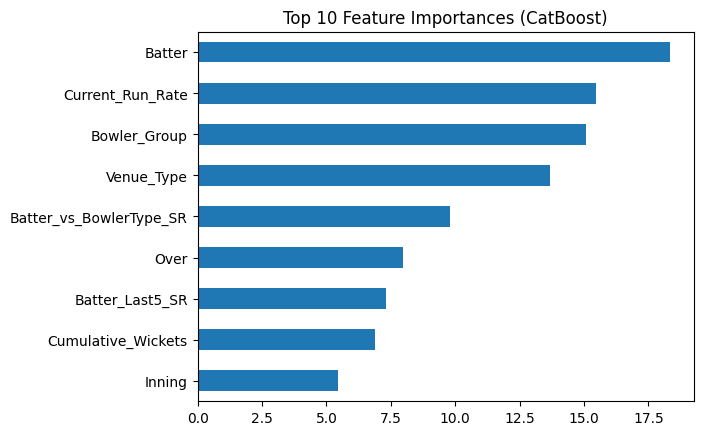

In [ ]:
feat_importances = pd.Series(
    best_model.get_feature_importance(),
    index=X_train.columns
)

feat_importances.nlargest(10).sort_values().plot(kind='barh')
plt.title('Top 10 Feature Importances (CatBoost)')
plt.show()

### 16. SHAP Explanations for Model Interpretability
This cell uses SHAP (SHapley Additive exPlanations) to interpret the CatBoost model's predictions. SHAP values help explain the contribution of each feature to a particular prediction.
1.  **Initialize Explainer**: Creates a `TreeExplainer` for the `best_model`.
2.  **Calculate SHAP Values**: Computes SHAP values for the test set, specifically focusing on the drivers of 'Pressure Balls' (Class 0) and 'Boundaries' (Class 2).
3.  **Generate Summary Plots**: Creates and saves SHAP summary plots for both 'Pressure Balls' and 'Boundaries'. These plots show the distribution of SHAP values for each feature across the dataset, indicating how each feature impacts the prediction of a specific outcome.
4.  **Display Plots**: Loads and displays the saved SHAP summary plots.

--- Drivers of Pressure Balls (Dot/Wicket) ---


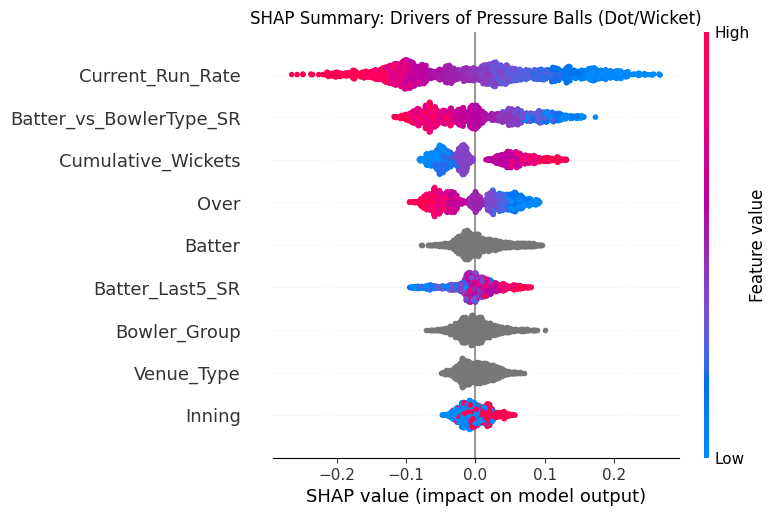


--- Drivers of Boundaries ---


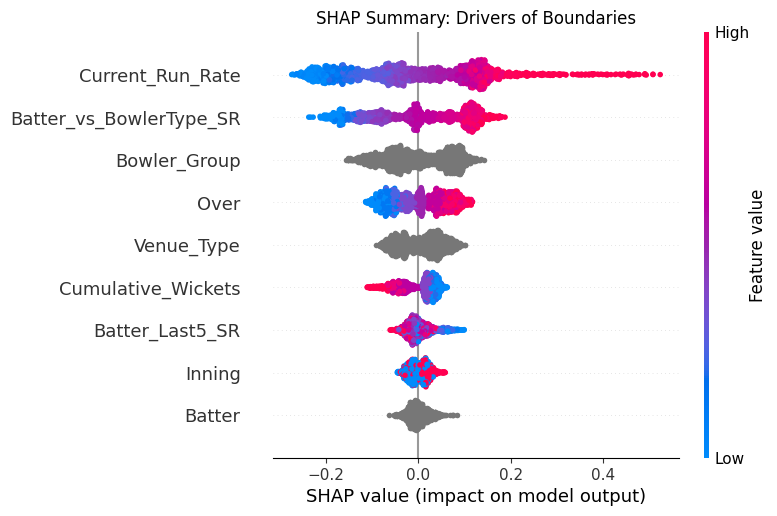

In [ ]:
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)

if isinstance(shap_values, list):
    shap_values_class0 = shap_values[0]
    shap_values_class2 = shap_values[2]
else:
    shap_values_class0 = shap_values[:, :, 0]
    shap_values_class2 = shap_values[:, :, 2]

# Plot Pressure Balls (Class 0)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class0, X_test, show=False)
plt.title("SHAP Summary: Drivers of Pressure Balls (Dot/Wicket)")
plt.savefig('shap_summary_pressure.png', bbox_inches='tight')
plt.close()

# Plot Boundaries (Class 2)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_class2, X_test, show=False)
plt.title("SHAP Summary: Drivers of Boundaries")
plt.savefig('shap_summary_boundaries.png', bbox_inches='tight')
plt.close()

print("--- Drivers of Pressure Balls (Dot/Wicket) ---")
display(Image(filename='shap_summary_pressure.png'))
print("\n--- Drivers of Boundaries ---")
display(Image(filename='shap_summary_boundaries.png'))

### 17. Define Batting Order Optimization Function
This cell defines the `optimize_batting_order` function, which is the core of the tactical optimizer. This function takes a live scenario, a list of available batters, the trained model, and training column names as input. It then:
1.  **Prepares Simulation Data**: For each available batter, it creates a simulation entry by combining the live scenario details with the batter's specific information (name, strike rate).
2.  **Predicts Probabilities**: Uses the `pipeline_model` (our `best_model`) to predict the probabilities of 'Pressure', 'Strike Rotation', and 'Boundary' outcomes for each simulated batter.
3.  **Calculates Tactical Score**: Computes a `Tactical Score` for each batter using a weighted formula: `(Boundary * 1.5) + (Rotation * 1.0) - (Pressure * 1.0)`. This score quantifies a batter's suitability for the given scenario.
4.  **Ranks Batters**: Returns a DataFrame of batters, sorted by their `Tactical Score` in descending order, along with their predicted probabilities for each outcome.

In [ ]:
def optimize_batting_order(scenario, available_batters, pipeline_model, training_columns):
    simulations = []

    # Prepare a base dictionary for scenario features, including defaults for missing ones
    base_scenario = {
        'Over': None, 'Cumulative_Wickets': None, 'Current_Run_Rate': None,
        'Inning': None, 'Venue_Type': None, 'Bowler_Group': None,
        'Batter_Last5_SR': 100.0, # Default if not provided in scenario, otherwise overridden
        'Batter_vs_BowlerType_SR': 100.0 # Default if not provided in scenario, otherwise overridden
    }
    base_scenario.update(scenario) # Override with provided scenario values

    for batter_info in available_batters:
        # Create a dictionary for this specific batter
        sim_data = base_scenario.copy()
        sim_data['Batter'] = batter_info['name']
        sim_data['Batter_Last5_SR'] = batter_info['sr'] # Use the provided SR
        simulations.append(sim_data)

    # Create DataFrame from simulations
    sim_df = pd.DataFrame(simulations)
    # Reorder columns to match training data, and ensure all training columns are present.
    # Missing columns (like Batter_Last5_SR, Batter_vs_BowlerType_SR if not in scenario) will use defaults from base_scenario.
    sim_df = sim_df[training_columns]

    # Predict probabilities using the CatBoost model
    probs = pipeline_model.predict_proba(sim_df)

    results = []
    for i, batter_info in enumerate(available_batters):
        p_pressure = probs[i][0] * 100
        p_rotation = probs[i][1] * 100
        p_boundary = probs[i][2] * 100

        # Calculate the Unified Tactical Score
        # Formula: (Boundary * 1.5) + (Rotation * 1.0) - (Pressure * 1.0)
        tactical_score = (p_boundary * 1.5) + (p_rotation * 1.0) - (p_pressure * 1.0)

        results.append({
            'Batter': batter_info['name'],
            'Tactical Score': round(tactical_score, 2),
            'Boundary_Prob (%)': round(p_boundary, 2),
            'Strike_Rotation (%)': round(p_rotation, 2),
            'Pressure_Prob (%)': round(p_pressure, 2)
        })

    results_df = pd.DataFrame(results)
    # Sort by the new Tactical Score
    results_df = results_df.sort_values(by='Tactical Score', ascending=False).reset_index(drop=True)

    return results_df

### 18. Apply Tactical Optimizer to a Live Scenario
This cell demonstrates how to use the `optimize_batting_order` function in a hypothetical live match scenario:
1.  **Define Live Scenario**: Sets up a dictionary `live_scenario` with current match conditions (Over, Wickets, Run Rate, Inning, Venue, Bowler Type).
2.  **Define Available Batters**: Creates a list `dugout_batters` with details (name and recent strike rate) of batters currently available to bat.
3.  **Rank Batters**: Calls the `optimize_batting_order` function with the defined scenario, batters, and the trained model.
4.  **Display Results**: Prints the `ranked_batters` DataFrame, showing the optimal batting order based on the `Tactical Score` and individual outcome probabilities for the given situation.

In [ ]:
live_scenario = {
    'Over': 7, 'Cumulative_Wickets': 2, 'Current_Run_Rate': 5.50,
    'Inning': 2, 'Venue_Type': 'Neutral', 'Bowler_Group': 'Pace'
}
dugout_batters = [{"name":'P Rathnayake', "sr": 164.04}, {"name": 'MD Shanaka', "sr": 153.06}, {"name":'PHKD Mendis', "sr": 167.92}, {"name":'DN Wellalage', "sr": 78.72}]

ranked_batters = optimize_batting_order(
    scenario=live_scenario,
    available_batters=dugout_batters,
    pipeline_model=best_model,
    training_columns=X_train.columns
)

print("--- TACTICAL MATCHUP OPTIMIZER ---")
print(ranked_batters.to_string(index=False))

--- TACTICAL MATCHUP OPTIMIZER ---
      Batter  Tactical Score  Boundary_Prob (%)  Strike_Rotation (%)  Pressure_Prob (%)
P Rathnayake           17.94              17.41                37.21              45.38
  MD Shanaka           16.92              17.68                36.36              45.96
 PHKD Mendis           16.24              15.84                38.31              45.84
DN Wellalage           12.37              16.31                35.79              47.90


### 19. Save the Trained Model and Training Columns
This cell saves the trained CatBoost model and the list of training column names to disk using `joblib`. This allows for easy deployment and reuse of the model without needing to retrain it. The `training_columns.joblib` file is crucial for ensuring that new data fed to the loaded model has the same feature order and names as the data it was trained on.

In [ ]:
import joblib

joblib.dump(best_model, 'catboost_strike_optimizer.joblib')
joblib.dump(list(X_train.columns), 'training_columns.joblib')

print("CatBoost model saved successfully.")

CatBoost model saved successfully.
